# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [2]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=289bb679-6aa3-40af-a16b-2633bfa9350b
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:01<00:00, 264MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=68ae306e-060a-4561-89b4-1e4930348116
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:02<00:00, 37.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=c9c129e5-29ac-4805-9701-3cebae6bb4f1
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:01<00:00, 73.1MB/s]


Now lets load the data and visualize the first few examples to see what we are dealing with!

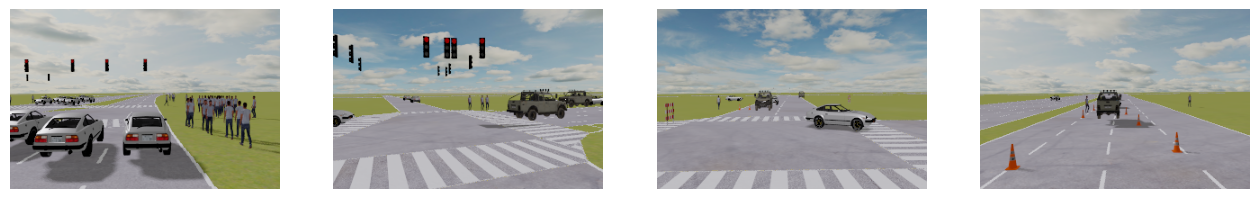

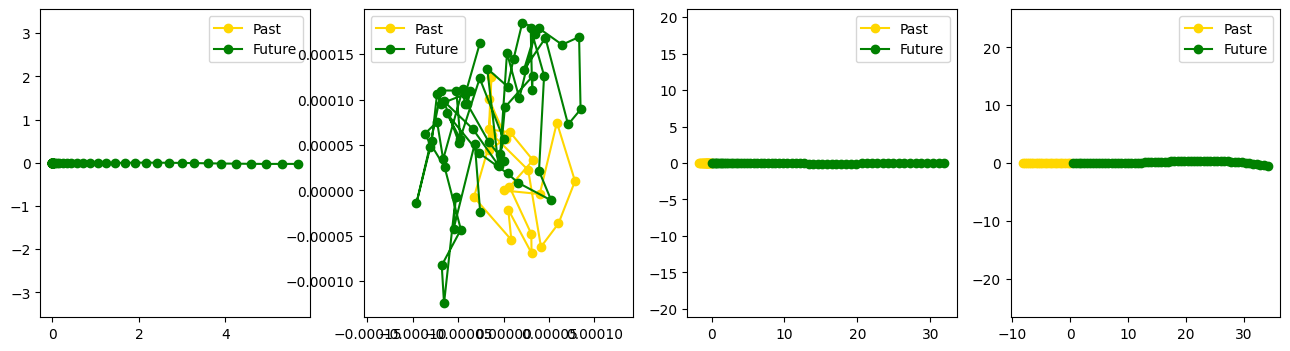

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [4]:
import torch
from torch.utils.data import Dataset
import pickle

dict_command = {'left':-1, 'forward':0, 'right':1}

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Convert numpy arrays to tensors
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1)
        history = torch.FloatTensor(data['sdc_history_feature'])
        command = torch.FloatTensor([dict_command[data['driving_command']]])
        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])
          return {
            'camera': camera,
            'history': history,
            'command': command,
            'future': future
          }
        else:
          return {
            'camera': camera,
            'history': history,
            'command': command,
          }



In [5]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [6]:
import torch
import torch.nn as nn

class DrivingPlanner(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN for processing camera images
        d_model_cam = 128
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2), # 200x300x3 -> 200x300x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # Divides size by 2: 200x300x16 -> 100x150x16
            #nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # 100x150x16 -> 100x150x32
            #nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2), # Divides size by 2: 100x150x32 -> 50x75x32
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2), # 50x75x32 -> 25x38x32
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(50*75*32, d_model_cam),
            nn.ReLU(),
            #nn.Linear(64, d_model_cam),
            #nn.ReLU()
        )

        # Transformer for processing past positions
        d_model_hist = 64
        self.embedder = nn.Linear(21*3, 64)
        #self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model_hist, nhead=4, batch_first=True), num_layers=2)
        self.transformer = nn.Sequential(
            nn.ReLU(),
            #nn.Linear(32, d_model_hist),
            #nn.ReLU()
        )

        # Duplication of driving command
        d_model_com = 8
        self.command = nn.Linear(1, d_model_com)

        # Decoder for predicting future trajectory
        self.decoder = nn.Sequential(
            nn.Linear(d_model_cam + d_model_hist + d_model_com, d_model_cam + d_model_hist + d_model_com),
            nn.ReLU(),
            nn.Linear(d_model_cam + d_model_hist + d_model_com, 60*3)
        )

    def forward(self, camera, history, command):
        # Process camera images
        visual_features = self.cnn(camera)

        # Process past positions
        history_flat = history.reshape(history.size(0), -1)
        history_embed = self.embedder(history_flat)
        # history_embed = history_flat
        history_encoded = self.transformer(history_embed)

        # Process driving command
        command = self.command(command)

        # Combine features
        combined = torch.cat([visual_features, history_encoded, command], dim=1)

        # Predict future trajectory
        future = self.decoder(combined)
        future = future.reshape(-1, 60, 3)  # Reshape to (batch_size, timesteps, features)

        return future

In [7]:
def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            command = batch['command'].to(device)
            future = batch['future'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, history, command)
            loss = criterion(pred_future[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                command = batch['command'].to(device)
                future = batch['future'].to(device)

                pred_future = model(camera, history, command)
                loss = criterion(pred_future, future)
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f}')

In [47]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner()

optimizer = optim.Adam(model.parameters(), lr=5e-3)

logger = Logger()

train(model, train_loader, val_loader, optimizer, logger, num_epochs=10)


Epoch 1/10 | Train Loss: 116719.5735 | Val Loss: 14.2421 | ADE: 3.6970 | FDE: 8.9994
Epoch 2/10 | Train Loss: 13.4358 | Val Loss: 10.0014 | ADE: 2.8223 | FDE: 7.5135
Epoch 3/10 | Train Loss: 9.9681 | Val Loss: 8.5372 | ADE: 2.7201 | FDE: 7.2506
Epoch 4/10 | Train Loss: 9.0325 | Val Loss: 8.1410 | ADE: 2.4246 | FDE: 6.6460
Epoch 5/10 | Train Loss: 8.4102 | Val Loss: 7.6794 | ADE: 2.4663 | FDE: 6.7508
Epoch 6/10 | Train Loss: 8.2423 | Val Loss: 8.1230 | ADE: 2.5849 | FDE: 7.1132
Epoch 7/10 | Train Loss: 8.7080 | Val Loss: 7.8164 | ADE: 2.6462 | FDE: 7.1378
Epoch 8/10 | Train Loss: 7.9935 | Val Loss: 7.3587 | ADE: 2.4028 | FDE: 6.7236
Epoch 9/10 | Train Loss: 7.6809 | Val Loss: 7.3888 | ADE: 2.5195 | FDE: 6.8862
Epoch 10/10 | Train Loss: 7.9849 | Val Loss: 7.2285 | ADE: 2.2728 | FDE: 6.4917


In [66]:
optimizer = optim.Adam(model.parameters(), lr=3e-3)
train(model, train_loader, val_loader, optimizer, logger, num_epochs=20)

Epoch 1/10 | Train Loss: 5.0553 | Val Loss: 6.5444 | ADE: 2.3204 | FDE: 6.3027
Epoch 2/10 | Train Loss: 4.8039 | Val Loss: 6.0175 | ADE: 2.2563 | FDE: 6.3050
Epoch 3/10 | Train Loss: 4.4709 | Val Loss: 6.4172 | ADE: 2.3878 | FDE: 6.5240
Epoch 4/10 | Train Loss: 4.7814 | Val Loss: 6.2903 | ADE: 2.1906 | FDE: 6.2333
Epoch 5/10 | Train Loss: 4.2847 | Val Loss: 6.3855 | ADE: 2.2758 | FDE: 6.5099
Epoch 6/10 | Train Loss: 4.1977 | Val Loss: 6.5280 | ADE: 2.2897 | FDE: 6.5620
Epoch 7/10 | Train Loss: 7.5827 | Val Loss: 6.2079 | ADE: 2.1777 | FDE: 6.0499
Epoch 8/10 | Train Loss: 5.8452 | Val Loss: 5.6558 | ADE: 2.1126 | FDE: 6.0155
Epoch 9/10 | Train Loss: 5.8615 | Val Loss: 5.6848 | ADE: 2.1625 | FDE: 6.1395
Epoch 10/10 | Train Loss: 5.5409 | Val Loss: 5.6385 | ADE: 2.0934 | FDE: 5.9470


In [68]:
optimizer = optim.Adam(model.parameters(), lr=2e-3)
train(model, train_loader, val_loader, optimizer, logger, num_epochs=10)

Epoch 1/10 | Train Loss: 5.2718 | Val Loss: 5.7857 | ADE: 2.1936 | FDE: 6.1933
Epoch 2/10 | Train Loss: 5.1818 | Val Loss: 6.0739 | ADE: 2.3634 | FDE: 6.5291
Epoch 3/10 | Train Loss: 5.2904 | Val Loss: 5.8217 | ADE: 2.1718 | FDE: 6.0765
Epoch 4/10 | Train Loss: 4.8974 | Val Loss: 6.0366 | ADE: 2.1970 | FDE: 6.2925
Epoch 5/10 | Train Loss: 4.6945 | Val Loss: 5.9220 | ADE: 2.2130 | FDE: 6.3096
Epoch 6/10 | Train Loss: 4.4857 | Val Loss: 6.1535 | ADE: 2.2299 | FDE: 6.2768
Epoch 7/10 | Train Loss: 4.3997 | Val Loss: 5.7684 | ADE: 2.0987 | FDE: 6.0523
Epoch 8/10 | Train Loss: 4.1062 | Val Loss: 6.4485 | ADE: 2.2726 | FDE: 6.3593
Epoch 9/10 | Train Loss: 3.7714 | Val Loss: 6.0467 | ADE: 2.1634 | FDE: 6.1975
Epoch 10/10 | Train Loss: 3.6143 | Val Loss: 6.1119 | ADE: 2.2459 | FDE: 6.3898


In [69]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, val_loader, optimizer, logger, num_epochs=10)

Epoch 1/10 | Train Loss: 3.1634 | Val Loss: 6.3484 | ADE: 2.2680 | FDE: 6.3631
Epoch 2/10 | Train Loss: 2.7911 | Val Loss: 6.2836 | ADE: 2.2448 | FDE: 6.4061
Epoch 3/10 | Train Loss: 2.6568 | Val Loss: 6.5727 | ADE: 2.2914 | FDE: 6.5684
Epoch 4/10 | Train Loss: 2.4524 | Val Loss: 6.4503 | ADE: 2.2734 | FDE: 6.5251
Epoch 5/10 | Train Loss: 2.3660 | Val Loss: 6.3022 | ADE: 2.2442 | FDE: 6.4623
Epoch 6/10 | Train Loss: 2.2560 | Val Loss: 6.4251 | ADE: 2.2824 | FDE: 6.5698
Epoch 7/10 | Train Loss: 2.1516 | Val Loss: 6.4944 | ADE: 2.3511 | FDE: 6.5429
Epoch 8/10 | Train Loss: 2.0536 | Val Loss: 6.3150 | ADE: 2.2849 | FDE: 6.5253
Epoch 9/10 | Train Loss: 2.0046 | Val Loss: 6.4247 | ADE: 2.2796 | FDE: 6.5392
Epoch 10/10 | Train Loss: 1.8488 | Val Loss: 6.3698 | ADE: 2.2822 | FDE: 6.5724


By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)

**We observe that the train loss is much smaller than the validation loss. This is called over-fitting. The model tends to "memorize" the training data and fails to generalize, making it perform really well on the training data, but not as good on data it hasn't been before.**


This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [51]:
# save the model
torch.save(model.state_dict(), "phase1_model.pth")

In [67]:
# load the model
model = DrivingPlanner()
model.load_state_dict(torch.load("phase1_model.pth"))

<All keys matched successfully>

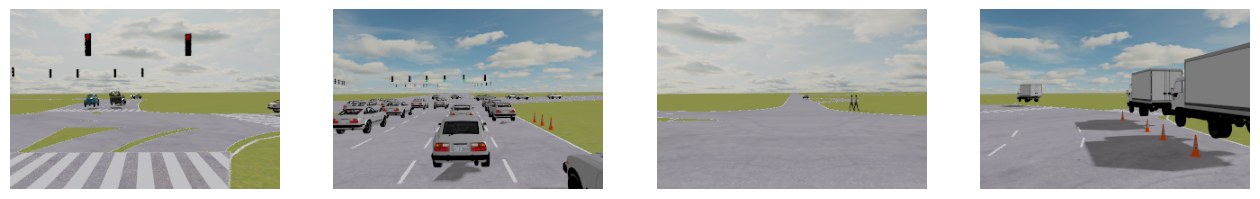

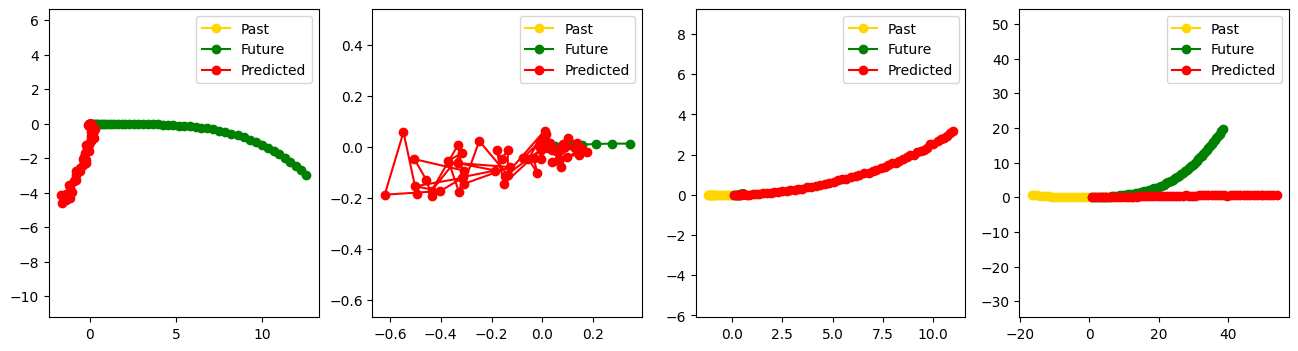

In [37]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
command = val_batch_zero['command'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, history, command)

camera = camera.cpu().numpy()
history = history.cpu().numpy()
command = command.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [27]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [28]:
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        command = batch['command'].to(device)

        pred_future = model(camera, history, command)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
